# DoWhy: A Simple example
* source link: https://www.pywhy.org/dowhy/v0.8/example_notebooks/dowhy_simple_example.html

In [1]:
import numpy as np
import pandas as pd

from dowhy import CausalModel
import dowhy.datasets

# Avoid printing dataconversion warnings from sklearn and numpy
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)

# Config dict to set the logging level
import logging
import logging.config
DEFAULT_LOGGING = {
    'version': 1,
    'disable_existing_loggers': False,
    'loggers': {
        '': {
            'level': 'WARN',
        },
    }
}

logging.config.dictConfig(DEFAULT_LOGGING)
logging.info("Getting started with DoWhy. Running notebook...")

In [2]:
data = dowhy.datasets.linear_dataset(
    beta=10,
    num_common_causes=5,
    num_instruments=2,
    num_effect_modifiers=1,
    num_samples=5000,
    treatment_is_binary=True,
    stddev_treatment_noise=10,
    num_discrete_common_causes=1
)

df = data["df"]
df

,X0,Z0,Z1,W0,W1,W2,W3,W4,v0,y
0,-0.740221,1.0,0.834907,0.170332,0.578872,-1.248177,-0.129347,1,True,6.799442
1,1.296027,1.0,0.118180,-2.046052,-1.181300,0.527719,-0.240873,0,True,15.297500
2,-0.173106,1.0,0.789762,-0.576068,0.337270,1.445852,0.931769,2,True,14.084343
3,-2.404746,1.0,0.245513,-0.824029,-0.012992,0.967769,-0.923473,1,True,-2.346579
4,-0.971977,1.0,0.865394,1.115982,-0.137517,-0.066571,2.571451,1,True,9.641635
...,...,...,...,...,...,...,...,...,...,...
4995,-0.727750,1.0,0.127102,-0.010328,0.631472,0.263547,1.432974,2,True,11.302550
4996,-0.188888,1.0,0.479739,-0.099387,0.085737,1.288758,1.084651,2,True,14.031318
4997,-1.264807,1.0,0.675299,-0.748614,0.954661,-1.888279,-0.889411,0,True,1.183630
4998,-1.597351,1.0,0.504434,0.988379,-0.124651,1.378578,-0.177544,2,True,5.140451


In [3]:
print(data["dot_graph"])
print(data["gml_graph"])

digraph {v0->y;W0-> v0; W1-> v0; W2-> v0; W3-> v0; W4-> v0;Z0-> v0; Z1-> v0;W0-> y; W1-> y; W2-> y; W3-> y; W4-> y;X0-> y;}
graph[directed 1node[ id "y" label "y"]node[ id "W0" label "W0"] node[ id "W1" label "W1"] node[ id "W2" label "W2"] node[ id "W3" label "W3"] node[ id "W4" label "W4"]node[ id "Z0" label "Z0"] node[ id "Z1" label "Z1"]node[ id "v0" label "v0"]edge[source "v0" target "y"]edge[ source "W0" target "v0"] edge[ source "W1" target "v0"] edge[ source "W2" target "v0"] edge[ source "W3" target "v0"] edge[ source "W4" target "v0"]edge[ source "Z0" target "v0"] edge[ source "Z1" target "v0"]edge[ source "W0" target "y"] edge[ source "W1" target "y"] edge[ source "W2" target "y"] edge[ source "W3" target "y"] edge[ source "W4" target "y"]node[ id "X0" label "X0"] edge[ source "X0" target "y"]]


* pygraphviz install issue: solved by `conda` ([link](https://stackoverflow.com/questions/59707234/issues-installing-pygrahviz-fatal-error-c1083-cannot-open-include-file-graph))

In [4]:
# with graph

model = CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    graph=data["gml_graph"]
)

model.view_model()

In [5]:
print(f"Treatment: {data['treatment_name']}")
print(f"Outcome: {data['outcome_name']}")

Treatment: ['v0']
Outcome: y


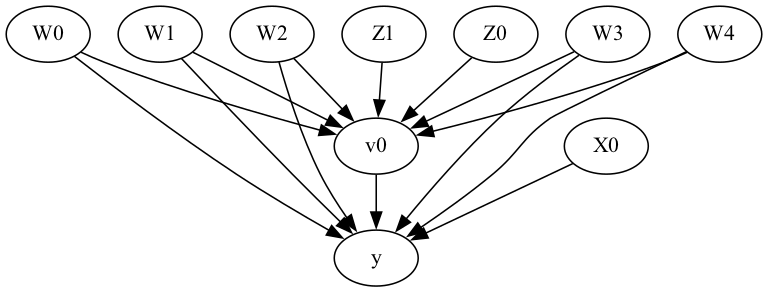

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [7]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W1,W2,U) = P(y|v0,W3,W4,W0,W1,W2)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                              -1⎤
 ⎢    d        ⎛    d          ⎞  ⎥
E⎢─────────(y)⋅⎜─────────([v₀])⎟  ⎥
 ⎣d[Z₁  Z₀]    ⎝d[Z₁  Z₀]      ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→{Z1,Z0})
Estimand assumption 2, Exclusion: If we remove {Z1,Z0}→{v0}, then ¬({Z1,Z0}→y)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [8]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print(f"Causal Estimate is {causal_estimate.value:.2f}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W1,W2,U) = P(y|v0,W3,W4,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W4+W0+W1+W2
Target units: ate

## Estimate
Mean value: 5.1615177688853935

Causal Estimate is 5.16


In [9]:
# Without graph
model= CausalModel(
    data=df,
    treatment=data["treatment_name"],
    outcome=data["outcome_name"],
    common_causes=data["common_causes_names"],
    effect_modifiers=data["effect_modifier_names"]
)

model.view_model()

In [10]:
print(f"Common causes: {data['common_causes_names']}")
print(f"Effect modifiers: {data['effect_modifier_names']}")

Common causes: ['W0', 'W1', 'W2', 'W3', 'W4']
Effect modifiers: ['X0']


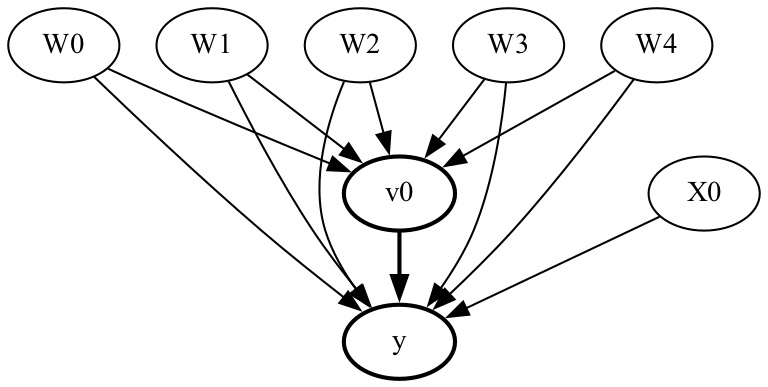

In [11]:
display(Image(filename="causal_model.png"))

In [12]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W1,W2,U) = P(y|v0,W3,W4,W0,W1,W2)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [13]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print(f"Causal Estimate is {causal_estimate.value:.2f}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                       
─────(E[y|W3,W4,W0,W1,W2])
d[v₀]                     
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W3,W4,W0,W1,W2,U) = P(y|v0,W3,W4,W0,W1,W2)

## Realized estimand
b: y~v0+W3+W4+W0+W1+W2
Target units: ate

## Estimate
Mean value: 5.1615177688853935

Causal Estimate is 5.16


# Create own test data

* $ T \rightarrow Y $
* $ C \rightarrow T $
* $ C \rightarrow Y $

* $T$: Treatment
* $C$: Confounder
* $Y$: Outcome

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

In [15]:
C = 10 * np.random.random(size=200)
T = np.array([1 if i + np.random.normal(0, 2) > 5 else 0 for i in C])
Y = np.array([1.2 * C[ix] + np.random.normal(0, 1) if i == 0 else 2 * C[ix] - 2 + np.random.normal(0, 1) for ix, i in enumerate(T)])

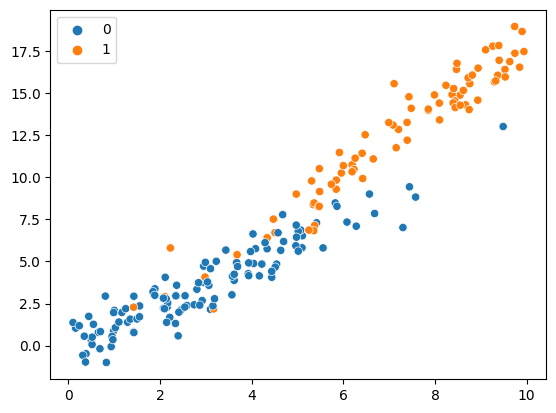

In [16]:
sns.scatterplot(x=C, y=Y, hue=T)
plt.show()

In [17]:
df = pd.DataFrame({
    'T': T, 'C': C, 'Y': Y
})
df

,T,C,Y
0,1,5.343084,8.372988
1,1,6.653553,11.088129
2,0,1.290806,1.392238
3,1,3.656961,4.927182
4,0,3.567994,3.017132
...,...,...,...
195,0,2.096475,2.193232
196,0,3.226275,5.009466
197,1,8.746131,14.017887
198,0,4.166346,4.145353


In [18]:
# Without graph
model= CausalModel(
    data=df,
    treatment='T',
    outcome='Y',
    common_causes='C',
)

model.view_model()

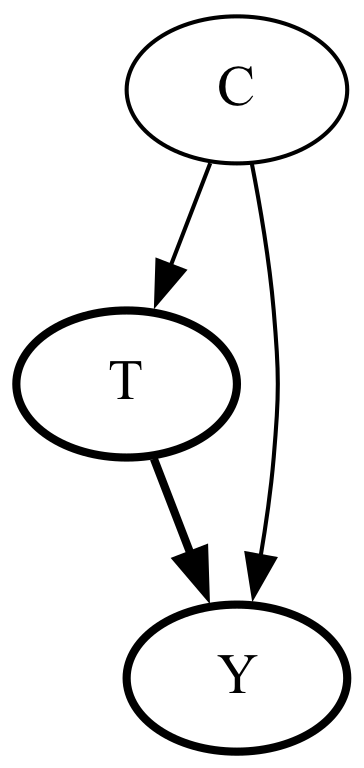

In [19]:
display(Image(filename="causal_model.png"))

In [20]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|C])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,C,U) = P(Y|T,C)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [21]:
causal_estimate = model.estimate_effect(identified_estimand, method_name="backdoor.propensity_score_stratification")
print(causal_estimate)
print(f"Causal Estimate is {causal_estimate.value:.2f}")

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
 d          
────(E[Y|C])
d[T]        
Estimand assumption 1, Unconfoundedness: If U→{T} and U→Y then P(Y|T,C,U) = P(Y|T,C)

## Realized estimand
b: Y~T+C
Target units: ate

## Estimate
Mean value: 3.896666034249333

Causal Estimate is 3.90


In [27]:
print(f"ATE with confounding: {df[df['T'] == 1]['Y'].mean() - df[df['T'] == 0]['Y'].mean(): .2f}")
print(f"ATE with deconfounding: {causal_estimate.value: .2f}")

ATE with confounding:  8.70
ATE with deconfounding:  3.90


In [24]:
res_random=model.refute_estimate(identified_estimand, causal_estimate, method_name="random_common_cause")
print(res_random)

Refute: Add a random common cause
Estimated effect:3.896666034249333
New effect:3.8966660342493333
p value:2.0



In [25]:
res_placebo=model.refute_estimate(identified_estimand, causal_estimate, method_name="placebo_treatment_refuter", placebo_type="permute")
print(res_placebo)

Refute: Use a Placebo Treatment
Estimated effect:3.896666034249333
New effect:-0.00891059212124051
p value:0.94



In [26]:
res_subset=model.refute_estimate(identified_estimand, causal_estimate, method_name="data_subset_refuter", subset_fraction=0.9)
print(res_subset)

Refute: Use a subset of data
Estimated effect:3.896666034249333
New effect:3.9050451610249626
p value:0.94

